# Exploration.08 - 뉴스기사 요약해보기

- 뉴스의 본문을 통해 요약 만들기
- 추상적 요약과 추출적 요약을 해볼 것
- 추상적 요약
    - 원문에 없는 단어도 사용하여 요약
    - 원문으로부터 내용이 요약된 새로운 문장을 생성
- 추출적 요약
    - 원문에 있는 단어를 추출하여 요약 
    - 원문 속 핵심 문장을 파악하여 요약

## 필요한 개념 설명

### 1. seq2seq (sequence-to-sequence)
- 입력된 시퀀스로부터 다른 도메인의 시퀀스를 출력하는 모델
- 주로 챗봇(Chatbot)과 기계 번역(Machine Translation)에서 사용됨
- https://wikidocs.net/24996

### 2. Encoder와 Decoder

![seq2seq](https://d3s0tskafalll9.cloudfront.net/media/images/E-21-2.max-800x600.png)

**이번 Exploration에서는 LSTM 모델을 두 번 엮어서 사용할 예정**
- 첫 번째 LSTM : Encoder
    - 원문을 Encoder에 입력
    - Encoder를 통해 하나의 고정된 벡터로 변환 (컨텍스트 벡터(context vector))
- 두 번째 LSTM : Decoder
    - 컨텍스트 벡터를 전달받아 한 단어씩 생성
    - 요약 문장을 완성함

### 3. LSTM이 바닐라 RNN과 다른 점
- LSTM : 다음 time step의 셀에 hidden state뿐만 아니라, cell state도 함께 전달
- 이번 exploration에는 인코더가 디코더에 전달하는 컨텍스트 벡터 또한 hidden state h와 cell state c 두 개의 값 모두 존재해야 함

- hidden state
    - LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터
    - LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수
- cell state
    - 일종의 컨베이어 벨트 역할
    - state가 꽤 오래 경과하더라도 그래디언트가 비교적 전파가 잘 되게 됨

### 4. seq2seq 구조에서 디코더
- 훈련 데이터의 예측 대상 시퀀스의 앞, 뒤에는 시작 토큰과 종료 토큰을 넣어주는 전처리를 통해 어디서 멈춰야 하는지를 지정해야함
- 이번 explation에서는 시작 토큰 SOS가 입력되면, 각 시점마다 단어를 생성하고 이 과정을 종료 토큰 EOS를 예측하는 순간까지 멈추지 않게 하고자 함

### 5. 어텐션 메커니즘(Attention Mechanism)
- RNN 계열의 인공 신경망(바닐라 RNN, LSTM, GRU)의 한계로 인해 output 정보에는 input 시퀀스의 많은 정보가 손실
- 어텐션 메커니즘 
    - 인코더의 모든 step의 hidden state의 정보가 컨텍스트 벡터에 전부 반영
    - 인코더의 모든 hidden state가 동일한 비중으로 반영되는 것이 아니라, 디코더의 현재 time step의 예측에 인코더의 각 step이 얼마나 영향을 미치는지에 따른 가중합으로 계산되는 방식
<br><br>
- 일반적인 seq2seq 모델 : 디코더로 전달되는 인코더의 컨텍스트 벡터는 예를 들어 인코더의 마지막 스텝의 hidden state인 h_5
- 어텐션 메커니즘 적용 : 인코더의 컨텍스트 벡터는 예를 들어 0.2h_1 +0.3h_2 +0.1h_3 +0.15h_4 +0.25h_5 가 될 수도 있음

## import Package

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

## 데이터 불러오기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


- text : 본문
- headlines : 요약 (추상적 요약시, 새롭게 만들어진 headline과 기존 headline을 비교하여 성능을 체크할 예정)

In [4]:
data.shape

(98401, 2)

- 총 98,401개의 뉴스
- 2개의 columns (headlines, text)

## 중복 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


- 중복 제거로 인해 기존 98,401개의 뉴스는 98,360개가 됨

## 결측치 확인

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 결측치는 없음

## 텍스트 정규화 준비
- 단어들 중에서는 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우가 있음  
(예를 들어서 it'll은 it will과 같고, mustn't과 must not은 사실 같은 표현)
- 기계 학습 전에 미리 같은 표현으로 통일시켜주는 것이 기계의 연산량을 줄일 수 있음

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


## 불용어 제거 준비

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- NLTK (Natural Language Toolkit)
    - 영어 기호, 통계, 자연어 처리를 위한 라이브러리
    - 100여개의 불용어가 미리 정리되어 있음

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

## 데이터 전처리

### 1. 데이터 전처리 함수 만들기

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

- remove_stopwords
    - 불용어에 포함된 단어들이 headlines에 들어가 있어야 자연스러운 문장이 됨
    - 따라서 text에서만 불용어를 제외시킬 수 있도록 if문을 통해서 나눔

### 2. 데이터 전처리 함수 작동 확인

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


### 3. 'text' 전처리하기

In [13]:
clean_text = []
# 전체 text 데이터에 대한 전처리 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

### 4. 'headlines' 전처리하기

In [14]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- False : remove_stopwords를 false로 하여 preprocess_sentence 함수 안에서 불용어를 제거하지 않도록 함

### 5. 정제한 데이터를 기존 data셋에 저장

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

## 정제 후 결측치 확인

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- 정제 후에도 결측치는 없음

## 시퀀스 길이 정하기

### 1. text와 headlines의 시퀀스 길이 체크

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


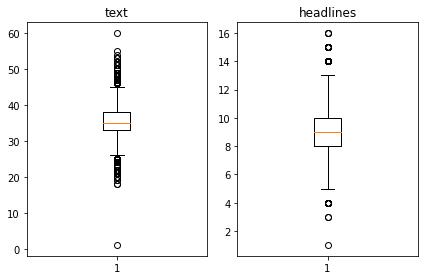

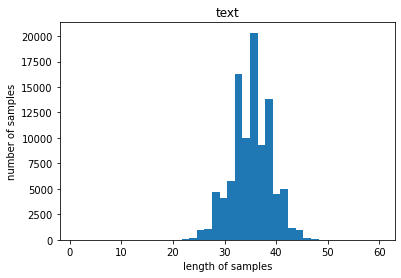

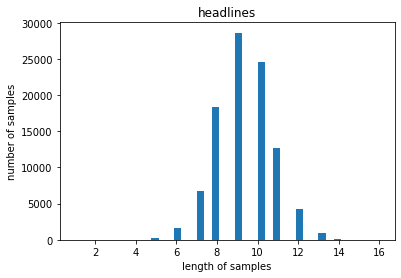

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 2. 대략적인 시퀀스 최소 길이 정하기

In [18]:
text_min_len = 25
headlines_min_len = 1

- 문장에 내용이 별로 없으면 패딩으로만 채워져서 학습에 도움이 별로 안될거 같다는 생각을 함
- 문장 최소 길이를 설정하여 좋은 데이터만 뽑으려 함
- text의 최소 길이는 25이상
- headlines의 최소 길이는 1이상

### 3. 대략적인 시퀀스 최대 길이 정하기

In [19]:
text_max_len = 45
headlines_max_len = 11

- text의 최대 길이는 45이하
- headlines의 최대 길이는 11이하

### 3. 정해준 시퀀스 길이 이하인 샘플의 비율 보기

In [20]:
def below_threshold_len(min_len, max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        if(len(s.split()) >= min_len):
            cnt = cnt + 1
  print('전체 샘플 중 길이가 %s이상, %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))

In [21]:
below_threshold_len(text_min_len, text_max_len, data['text'])
below_threshold_len(headlines_min_len, headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 25이상, 45 이하인 샘플의 비율: 0.994408296055307
전체 샘플 중 길이가 1이상, 11 이하인 샘플의 비율: 0.9449877999186661


### 4. 지정해준 시퀀스의 길이 이하의 문장을 제외시켜버리기

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) >= text_min_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) >= headlines_min_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98127


### 5. 지정해준 시퀀스의 길이 이상의 문장을 제외시켜버리기

In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 92442


- 문자의 길이를 지정해준 후, data의 갯수는 89,246개가 됨

## 시작과 끝을 알리는 토큰 만들기

- 두번째 RNN인 Decoder에서는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈춤
- 뉴스를 요약해야하므로 Decoder에 쓰일 문장은 'headlines'에서 가공함

In [24]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
encoder_input.shape, decoder_input.shape, decoder_target.shape

((92442,), (92442,), (92442,))

In [27]:
# encoder_input

In [28]:
# decoder_input

In [29]:
# decoder_target

## train, test 분리

### 1. 데이터의 순서를 랜덤으로 섞어줌

In [30]:
encoder_input[0]

'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'

In [31]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [32]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [33]:
encoder_input[0]

'russian foreign minister sergey lavrov monday said russia ready support pakistan eliminating terrorists country pakistan interest getting rid terrorist organisations using territory lavrov added comes us warned pakistan act terrorists everything destroy'

### 2. train과 test를 나눌 비율 정함

In [34]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18488


- 전체 data에서 test는 0.2 비율로 18,488개만큼을 분리할 예정

### 3. train, test 분리

In [35]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 73954
훈련 레이블의 개수 : 73954
테스트 데이터의 개수 : 18488
테스트 레이블의 개수 : 18488


## 'text'로부터 단어사전 만들기 (Encoder에 쓰일 부분)

### 1. 토큰 만들기

In [36]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [37]:
for idx in src_tokenizer.index_word:
    print(idx, ":", src_tokenizer.index_word[idx])

    if idx >= 10: break

1 : said
2 : india
3 : year
4 : added
5 : us
6 : also
7 : government
8 : first
9 : police
10 : people


- 토큰의 인덱스 순서는 토큰의 빈도수에 의해 결정됨
- https://wikidocs.net/31766

In [38]:
for k, v in src_tokenizer.word_counts.items():
    if k == 'said':
        print(k, ':', v)
    if k == 'year':
        print(k, ':', v)
    if k == 'india':
        print(k, ':', v)

said : 39687
year : 13414
india : 13646


- 가장 많은 빈도수를 보인 said는 41,446번 나타남

### 2. 희귀단어 비율 확인

In [39]:
threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68048
등장 빈도가 10번 이하인 희귀 단어의 수: 51050
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16998
단어 집합에서 희귀 단어의 비율: 75.02057371267341
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.093297728990826


### 3. 단어사전 만들기

In [40]:
src_vocab = 17000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 17,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

- 등장 빈도가 10번 이하인 희귀 단어를 제외한 단어들은 16,850개이므로 대략적인 17,000개의 단어를 가진 단어사전을 생성

### 4. 단어를 정수 시퀀스로 인코딩함

In [41]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[335, 356, 15, 6360, 8370, 58, 1, 300, 1250, 349, 46, 9928, 944, 38, 46, 984, 508, 7842, 1019, 2552, 144, 2300, 8370, 4, 61, 5, 718, 46, 493, 944, 1708, 4390], [338, 157, 4896, 664, 93, 1189, 422, 157, 2768, 81, 3, 59, 177, 1605, 2502, 189, 33, 1854, 59, 177, 73, 157, 33, 1854, 177, 1222, 1189, 2502, 15518, 15518, 1189, 16224, 2017, 3501, 143, 189, 1854, 199, 1364], [424, 120, 3835, 3373, 455, 1355, 266, 92, 424, 3032, 1308, 10381, 1944, 49, 135, 54, 1944, 2001, 11822, 78, 1300, 424, 5369, 2600, 140, 224, 590, 424, 963, 22, 6017, 228, 166]]


## 'headlines'로부터 단어사전 만들기 (Decoder에 쓰일 부분)

### 1. 토큰 만들기

In [42]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [43]:
for idx in tar_tokenizer.index_word:
    print(idx, ":", tar_tokenizer.index_word[idx])

    if idx >= 10: break

1 : sostoken
2 : to
3 : in
4 : for
5 : of
6 : on
7 : india
8 : with
9 : after
10 : at


### 2. 희귀단어 비율 확인

In [44]:
threshold = 10
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29514
등장 빈도가 9번 이하인 희귀 단어의 수: 22081
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7433
단어 집합에서 희귀 단어의 비율: 74.81534187165413
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.5717876192231355


### 3. 단어사전 만들기

In [45]:
tar_vocab = 7000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

- 등장 빈도가 9번 이하인 희귀 단어를 제외한 단어들은 7,384개이므로 대략적인 7,000개의 단어를 가진 단어사전을 생성

### 4. 단어를 정수 시퀀스로 인코딩함

In [46]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 860, 3, 546, 86, 4, 432, 141], [1, 1045, 1370, 329, 369, 666, 1535], [1, 186, 66, 50, 686, 986, 450], [1, 399, 2673, 4648, 5, 1190, 91, 364], [1, 264, 473, 195, 3, 32]]
target
decoder  [[860, 3, 546, 86, 4, 432, 141, 2], [1045, 1370, 329, 369, 666, 1535, 2], [186, 66, 50, 686, 986, 450, 2], [399, 2673, 4648, 5, 1190, 91, 364, 2], [264, 473, 195, 3, 32, 2]]


- 1 : sostoken (문장 시작 토큰)
- 2 : eostoken (문장 끝 토큰

## 'healines'에서 내용이 없는 것 제외시키기

In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 73954
훈련 레이블의 개수 : 73954
테스트 데이터의 개수 : 18488
테스트 레이블의 개수 : 18488


- len(sentence) == 1 : sostoken, eostoken의 존재로 시퀀스의 길이가 0인 것은 없음
- 'headlines'부분에서는 내용이 없는 데이터는 없음

## 시퀀스에 패딩

In [48]:
text_max_len, headlines_max_len

(45, 11)

- 'text'와 'headlines' 시퀀스 최대 길이는 45와 11로 지정해줬었음

In [49]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

- 'pre padding'을 통해 시퀀스의 최대 길이에서 부족한 부분만큼 앞단에 0을 채움
- 뒷단의 입력이 중요한 recurrent model 입장에서는 'pre padding'이 'post padding'보다 좋은 성능을 가짐
- https://koreapy.tistory.com/604

## Encoder 모델 설계하기

In [50]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- Encoder 모델에서는 'text'부분을 받아 학습하고 컨텍스트 벡터(context vector) 출력함

- 임베딩의 input_dim은 src_vocab으로 지정해준 17,000으로 들어옴
- 임베딩의 output_dim 벡터의 차원은 256으로 정의
- hidden state의 크기를 512로 정의 (LSTM의 유닛의 갯수)

- hidden state의 크기를 늘리는 것 : LSTM 층 1개의 용량을 늘림
- LSTM 층 수를 여러개 쓰는 것 : 모델의 용량을 늘림

- cuDNN 
    - CUDA Deep Neural Networkrecurrent 
    - 심층 신경망에서 사용하기 위해 GPU를 가속할 수 있게 함
    - recurrent_dropout을 사용할 때에는 cuda를 사용할 수 없음

![recurrent dropout](https://d3s0tskafalll9.cloudfront.net/media/images/seukeurinsyas_2021-10-28_17-19-50.max-800x600.png)

- 일반적인 dropout : 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법
- recurrent dropout : dropout을 레이어가 아닌 time step마다 해주는 방식, 즉 time step의 입력을 랜덤으로 생략
<br><br>
- recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지
<br><br>
- Variational Dropout : dropout과 recurrent dropout을 모두 사용한 것

- dropout
![dropout](https://ko.d2l.ai/_images/dropout2.svg)

- 위의 예시에서는 dropout으로 인해 h2와 h5가 제외됨
- h2와 h5에 대해서는 back propagation도 적용되지 않음
- h들 중 일부를 제외하므로써 특정 h에 대해 의존하지 않게함
- overfitting 방지
- 테스트 시에는 확실한 결과를 얻기 위해서 dropout을 사용하지 않음
- https://ko.d2l.ai/chapter_deep-learning-basics/dropout.html

- return_sequences : 출력 시퀀스 또는 전체 시퀀스에서 마지막 출력을 반환할지 여부
    - 디폴트값 : False
    - 현재는 True이므로 시퀀스 길이(토큰의 갯수)인 45만큼을 벡터로 변환하여 출력

## Decoder 모델 설계하기

- LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 해요.

In [51]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [52]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

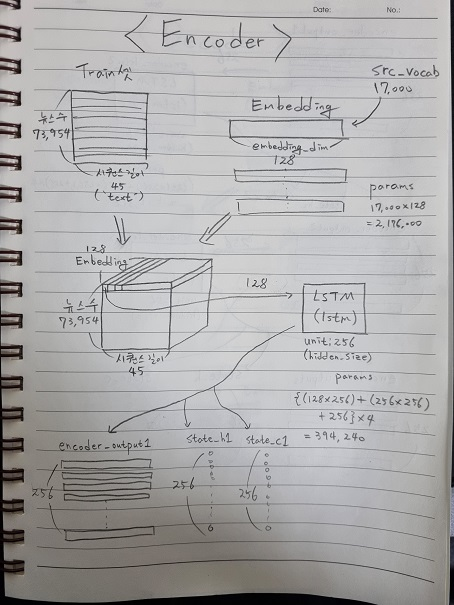

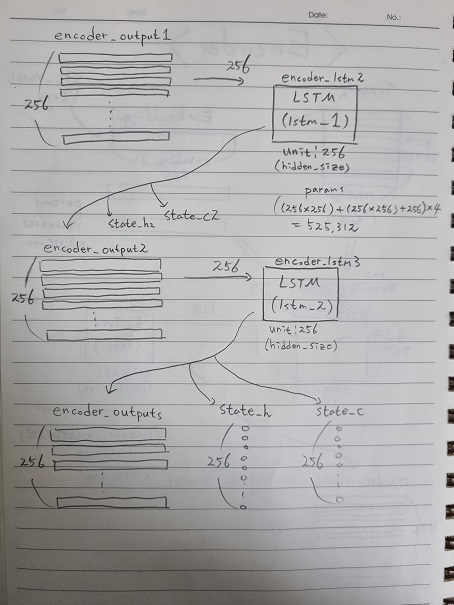

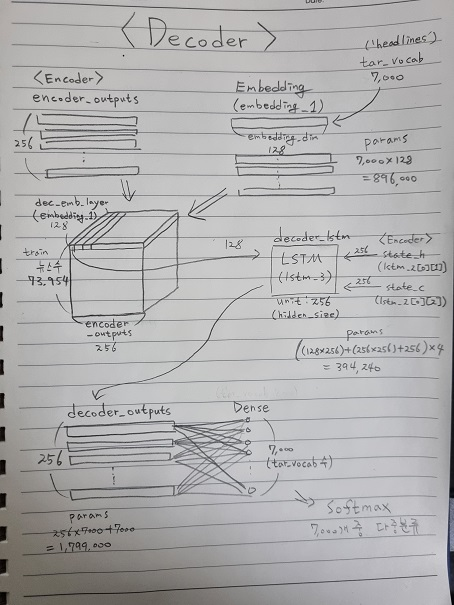

- 상세한 구조를 이해하기 어려워 노트에 적어가면서 파악해보려 노력함

- dense
    - Decoder의 출력층
    - 'headlines'의 단어장인 tar_vocab의 7000단어 중 하나를 선택해야함
    - 다중 클래스 분류 문제이므로 activation으로 softmax를 사용

## 어텐션 메커니즘

In [53]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2176000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

-  TensorFlow에 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 결합

- Encoder의 hidden state와 Decoder의 hidden state들을 어턴션 함수의 입력으로 사용
- 어텐션 함수가 리턴한 값을 예측 시에 Decoder의 hidden state와 함께 활용하는 형태로 작동

## 모델 훈련하기

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=512, callbacks=[es], epochs=80)

Epoch 1/80
145/145 [==============================] - 100s 631ms/step - loss: 5.7902 - val_loss: 5.3959
Epoch 2/80
145/145 [==============================] - 91s 630ms/step - loss: 5.3820 - val_loss: 5.2640
Epoch 3/80
145/145 [==============================] - 91s 631ms/step - loss: 5.2752 - val_loss: 5.1930
Epoch 4/80
145/145 [==============================] - 92s 632ms/step - loss: 5.1890 - val_loss: 5.1046
Epoch 5/80
145/145 [==============================] - 92s 632ms/step - loss: 5.0770 - val_loss: 5.0014
Epoch 6/80
145/145 [==============================] - 91s 630ms/step - loss: 4.9643 - val_loss: 4.9118
Epoch 7/80
145/145 [==============================] - 91s 629ms/step - loss: 4.8567 - val_loss: 4.8248
Epoch 8/80
145/145 [==============================] - 92s 632ms/step - loss: 4.7630 - val_loss: 4.7509
Epoch 9/80
145/145 [==============================] - 91s 631ms/step - loss: 4.6792 - val_loss: 4.6882
Epoch 10/80
145/145 [==============================] - 92s 633ms/step - 

- EarlyStopping : 특정 조건이 충족되면 훈련을 멈추는 역할
- monitor='val_loss', patience=2 : 'val_loss'가 증가하는 현상이 2번 일어나면 조기 종료함
- epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있음

- callbacks : 훈련, 평가 또는 추론 중에 Keras 모델의 동작을 사용자 정의할 수 있는 도구
- https://www.tensorflow.org/guide/keras/custom_callback?hl=ko

- 최소 val_loss는 epoch 58번째에서 3.6864

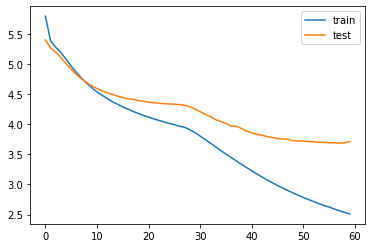

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- Early stop으로 인해 그래프에서 epoch는 22까지만 표기됨
- train loss와 test validation loss 둘다 떨어지다가 잠깐 주춤하는 경향을 보임

## 인퍼런스 모델 구현하기

- 인퍼런스 모델을 별도로 설계하는 이유
    - 인퍼런스 단계에서는 정답이 없음
    - 만들어야 할 문장의 길이만큼 Decoder가 반복 구조로 동작해야함

- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야함

### 1. 정수로 전환된 데이터를 실제 데이터로 복원하기 위한 사전 준비

In [56]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### 2. 모델 설계

In [57]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

- 인퍼런스에서의 Encoder 모델은 'text'를 가공한 시퀀스를 입력으로 받음
- inputs=encoder_inputs :  ( encoder_inputs = Input(shape=(text_max_len,)) )

In [58]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 45, 128)           2176000   
_________________________________________________________________
lstm (LSTM)                  [(None, 45, 256), (None,  394240    
_________________________________________________________________
lstm_1 (LSTM)                [(None, 45, 256), (None,  525312    
_________________________________________________________________
lstm_2 (LSTM)                [(None, 45, 256), (None,  525312    
Total params: 3,620,864
Trainable params: 3,620,864
Non-trainable params: 0
_________________________________________________________________


- 인퍼런스에 대한 Encoder 모델 구성은 똑같음

In [60]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    896000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

- 인퍼런스에 대한 Decoder 모델에서는 몇가지가 추가됨
<br><br>
- decoder_state_input_h, decoder_state_input_c
    - lstm의 initial_state를 위해 추가됨
    - lstm_3에 input_3[0][0], input_4[0][0]으로 연결되어있음
<br><br>
- decoder_hidden_state_input
    - Input(shape=(text_max_len, hidden_size)) : 'text'부분의 시퀀스 길이 45, hidden_size인 512

### 3. 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [61]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 원문과 정수 시퀀스를 변환시키는 함수 만들기

In [62]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

- healines 부분은 시작과 끝을 알리는 토큰이 아닌 것을 temp에 추가

## 테스트 데이터로 성능 비교 (추상적 요약)

- 원문 : text
- 실제 요약 : headlines
- 예측 요약 : 학습을 통한 추상적 요약

In [63]:
for i in range(30, 80):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : national pharmaceutical pricing authority capped prices essential including used treatment cancer pain heart conditions skin problems regulator expected prices anywhere reports said companies selling products prices higher new limits reduce prices immediately 
실제 요약 : govt caps prices of cancer drugs heart condition medicines 
예측 요약 :  patients to get free treatment for cancer in delhi university


원문 : chief minister mehbooba mufti wednesday urged police attack families militants asking ensure surrender militants said militants kill people police personnel houses set fire forces whether security forces police things 
실제 요약 : police should not attack families of militants cm 
예측 요약 :  militants in tripura cm to fight with militants in tripura


원문 : us company american green maker marijuana products acquired town california million company plans invest million create weed friendly tourist destination notably purchase includes acres land general store hotel school building mineral 

- **추상적 요약 평가**
    - 원문의 핵심을 뽑아서 새로운 문장을 만들어냄
    - 생각보다 좋은 성능을 보임
    - 두 단어를 연속으로 사용하기도 함 : trump has nothing to do not have good trump trump
    - 어법에 맞지 않는 문장이 발생하기도 함 : melania melania wife tried to melania school kids baby boy
    - 다른 내용을 요약하기도 함 : year old baby dies after being stuck in us house
        - 원문에서 아기는 얼굴에 화상을 입었다고만 나왔지만 예측에서는 죽었다고 요약함

## 추출적 요약

- 추상적 요약 : 본문에 없는 단어도 사용하여 새로운 문장을 만들어 요약함
- 추출적 요약 : 본문에 존재하는 단어구, 문장을 뽑아서 요약함

- Summa : 추출적 요약을 위한 모듈인 summarize를 제공하고 있어 아주 간단하게 실습 가능

In [64]:
from summa.summarizer import summarize

In [74]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

### 1. 문제 발생

In [81]:
data['text'][1]

"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."

In [89]:
summarize(data['text'][1], words=10)

''

In [93]:
data['text'][2]

"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history."

In [94]:
summarize(data['text'][1], words=10)

''

In [90]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [92]:
summarize(data['text'][0], words=10)

"upGrad's Online Power Learning has powered 3 lakh+ careers."

In [95]:
data['text'][6]

"India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108."

In [97]:
summarize(data['text'][6], words=10)

"India's previous lowest ODI total in New Zealand was 108."

In [98]:
len(data['text'][1]), len(data['text'][2]) ## summarize()를 사용해도 요약되지 않는 문장

(347, 360)

In [99]:
len(data['text'][0]), len(data['text'][6]) ## summarize()를 사용할때 요약되는 문장

(375, 339)

In [105]:
lst_temp = []
for i in data['text'][1].split():
    lst_temp.append(i)
len(list(set(lst_temp)))

54

In [106]:
lst_temp = []
for i in data['text'][6].split():
    lst_temp.append(i)
len(list(set(lst_temp)))

44

- **'text'의 일부 문장은 summarize()를 사용해도 요약되지 않는 문제 발생**
- summarize()로 요약되는 문장과 요약되지 않는 문장을 비교해봤지만 원인을 찾을 수 없었음
- 중복되지 않는 단어 수를 비교해봤지만 원인을 찾을 수 없음
    - data['text'][0] : summarize()로 요약 불가능, 중복되지 않는 단어 수는 54개
    - data['text'][6] : summarize()로 요약 가능, 중복되지 않는 단어 수는 44개
- 더 많은 실험이 필요

### 2. summarize()로 요약 가능한 문장 5개 뽑아보기

In [107]:
cnt = 0
for i, s in enumerate(txt):
    if summarize(txt[i], words=5) != '':
        print(i)
        cnt += 1
    if cnt == 5:
        break

0
6
25
142
174


- 0, 6, 25, 142, 174번째 문장들은 summarize()로 요약 가능

In [108]:
data['text'][0]

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [109]:
data['text'][25]

"Former Windies fast bowler Curtly Ambrose dismissed seven Australian batsmen within a span of 32 balls giving away just one run, in a Test match on January 30, 1993. Ambrose's spell helped his team bowl out Australia for 119 in the first innings, after being 85 for 2 at one point. Ambrose ended with first-innings figures of 18-9-25-7."

### 3. 추출적 요약하기

In [110]:
for i in [0, 6, 25, 142, 174]:
    print('원문 : {}'.format(data['text'][i]))
    print('실제 요약 : {}'.format(data['headlines'][i]))
    print('추출적 요약 : {}'.format(summarize(data['text'][i], words=10)))
    print('\n')

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.
실제 요약 : India get all out for 92, their lowest ODI total in New Zealand
추출적 요약 : India's previous lowest ODI total in New Zealand

- 추출적 요약을 한 결과 대체로 마지막 문장을 가져오는 경향을 보임  
(문장을 그대로 가져왔기 때문에 문법은 틀리지 않았을 것으로 예상됨)
- 따라서 올바른 요약으로 볼 수 없다고 판단됨

## 회고

### 1. 새로 알아갔던 점
 - 딥러닝으로 추상적 요약을 구현할 수 있다는 점을 알게 됨
 - 딥러닝 모델 두개를 엮어서 사용할 수 있다는 점을 알게 됨
 - 어텐션 메커니즘에 대해 대략적으로 알아봤음

### 2. 흥미로웠던 점
 - 복잡하게 보였던 모델 구조를 파악하려 노력했을 때 흥미로웠음 (아직 자세하게는 파악하지 못함, 특히 어텐션 부분)
 - 추상적 요약을 생각보다 잘했던 점 (일부는 원문에 없는 내용을 잘못 요약하기도 함)

### 3. 아쉬웠던 점
 - summarize()가 요약을 하지 못해 원인을 찾는데 시간을 너무 많이 소모했음
 - 가장 아쉬운점은 summarize()가 요약하지 못한 원인을 찾지 못함
 - 어텐션 메커니즘에 대해 대략적으로는 이해했지만 계산이 어떻게 이뤄지는지는 파악하지 못함
     - 더 찾다보니 bptt같은 내용이 등장하였는데 정확하게 이해하지 못함

### 4. 앞으로의 다짐
 - RNN 계열의 모델에 조금 더 자세히 알아보고 익숙해져야겠다는 생각을 하게됨 (반성...)